In [19]:
import pandas as pd
import torch
from torch import nn
from torchsummary import summary
from collections import OrderedDict
from torchvision.models import resnet50, densenet121, inception_v3
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from PIL import Image
import numpy as np

In [20]:
from skimage.io import imread
import numpy as np
from skimage.transform import resize
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
from torchvision import models, transforms
import os
import cv2

In [21]:
BATCH_SIZE = 16

In [22]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define the directories for training, validation, and test sets
train_dir = '/home/samo/dev/liver/data_split/train'
val_dir = '/home/samo/dev/liver/data_split/val'
test_dir = '/home/samo/dev/liver/data_split/test'

# Print the number of images in each dataset and class Few, Many, None
print('Train:')
print('Few:', len(os.listdir(os.path.join(train_dir, 'Few'))))
print('Many:', len(os.listdir(os.path.join(train_dir, 'Many'))))
print('None:', len(os.listdir(os.path.join(train_dir, 'None'))))

print('Val:')
print('Val Few:', len(os.listdir(os.path.join(val_dir, 'Few'))))
print('Val Many:', len(os.listdir(os.path.join(val_dir, 'Many'))))
print('Val None:', len(os.listdir(os.path.join(val_dir, 'None'))))

print('Test:')
print('Test Few:', len(os.listdir(os.path.join(test_dir, 'Few'))))
print('Test Many:', len(os.listdir(os.path.join(test_dir, 'Many'))))
print('Test None:', len(os.listdir(os.path.join(test_dir, 'None'))))

Train:
Few: 3444
Many: 1323
None: 3258
Val:
Val Few: 1148
Val Many: 20
Val None: 181
Test:
Test Few: 1148
Test Many: 21
Test None: 182


In [23]:

class AugmentedDataset(Dataset):
    def __init__(self, root_dir, transform=None, train=False):
        self.dataset = datasets.ImageFolder(root_dir)
        self.transform = transform
        self.train = train
        self.classes = self.dataset.classes
        
        if self.train:
            self.train_augs = A.Compose([
                A.RandomResizedCrop(height=512, width=512, scale=(0.8, 1.0), p=0.5),
                A.GaussNoise(var_limit=(5.0, 30.0), p=0.2),
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
            ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        
        if self.train:
            # Convert PIL Image to numpy array
            img_np = np.array(img)
            # Apply Albumentations augmentations
            augmented = self.train_augs(image=img_np)
            img_np = augmented['image']
            # Convert back to PIL Image
            img = Image.fromarray(img_np)
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

# Define your transformations
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize all images to 512x512
    transforms.ToTensor()
])

# Create datasets
train_dataset = AugmentedDataset(train_dir, transform=transform, train=True)
val_dataset = AugmentedDataset(val_dir, transform=transform, train=False)
test_dataset = AugmentedDataset(test_dir, transform=transform, train=False)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


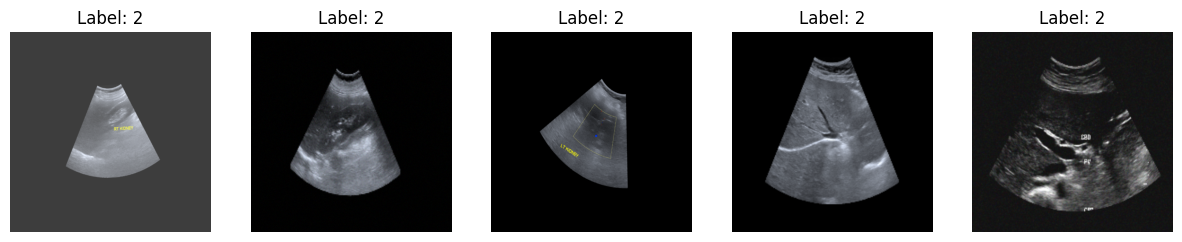

In [24]:
# Function to get images of a specific label
def get_images_by_label(dataloader, label, num_images=1):
    images = []
    labels = []
    for batch_images, batch_labels in dataloader:
        for img, lbl in zip(batch_images, batch_labels):
            if lbl == label:
                images.append(img)
                labels.append(lbl)
                if len(images) >= num_images:
                    return images, labels
    return images, labels

# Example usage: Get 5 images of label 0
label_to_display = 2
num_images_to_display = 5
images, labels = get_images_by_label(train_loader, label_to_display, num_images_to_display)

# Display the images
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))
for i, (img, lbl) in enumerate(zip(images, labels)):
    axes[i].imshow(img.permute(1, 2, 0))
    axes[i].set_title(f'Label: {lbl}')
    axes[i].axis('off')
plt.show()

In [25]:
num_class = len(train_loader.dataset.classes)
print(num_class)
print(train_loader.dataset.classes)

3
['Few', 'Many', 'None']


In [26]:
class Classifier(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        self.drop_out = nn.Dropout()
        self.linear = nn.Linear(2048, num_class)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.drop_out(x)
        x = self.linear(x)
        #x = torch.softmax(x, dim=-1)
        return x


class Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        base_model = resnet50(pretrained=False)
        encoder_layers = list(base_model.children())
        self.backbone = nn.Sequential(*encoder_layers[:9])
                        
    def forward(self, x):
        return self.backbone(x)

In [27]:
backbone = Backbone()
classifier = Classifier(num_class=num_class)

/home/samo/dev/liver/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/samo/dev/liver/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [28]:
backbone.load_state_dict(torch.load("models/ResNet50.pt"))


<All keys matched successfully>

In [16]:
# Gather all labels from the training dataset
all_labels = []
for batch in train_loader:
    all_labels.extend(batch[1].cpu().numpy())

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(all_labels), y=all_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [17]:
print(class_weights)
print(train_dataset.classes)

tensor([0.7767, 2.0219, 0.8211])
['Few', 'Many', 'None']


In [18]:
for batch in train_loader:
    print(batch[1])
    break

tensor([2, 0, 1, 0, 2, 0, 2, 2, 1, 2, 2, 0, 0, 0, 0, 2])


In [29]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from torch.nn.functional import softmax
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_metrics(y_true, y_pred, y_prob):
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate metrics for each class
    metrics = []
    for i in range(len(cm)):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - TP - FP - FN
        
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        
        metrics.append({
            'sensitivity': sensitivity,
            'specificity': specificity
        })
    
    # Calculate overall accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate ROC-AUC
    auc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='weighted')
    
    return accuracy, metrics, auc, cm

def plot_confusion_matrix(cm, class_names, fold_num=0):
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'confusion_matrix_fold{fold_num}.png')
    plt.close()

def train_model(model, criterion, optimizer, num_epochs=30, fold_num=0, device='cuda'):
    min_valid_loss = np.inf
    best_metrics = {}
    class_names = ['None', 'Few', 'Many']  # Update these based on your class labels

    for e in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_preds, train_labels = [], []

        for i_batch, batch in enumerate(train_loader):
            data, labels = batch[0].to(device, dtype=torch.float), batch[1].to(device)
            
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        # Validation phase
        model.eval()
        valid_loss = 0.0
        val_preds, val_labels, val_probs = [], [], []

        with torch.no_grad():
            for i_batch, batch in enumerate(val_loader):
                data, labels = batch[0].to(device, dtype=torch.float), batch[1].to(device)
                
                outputs = model(data)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * data.size(0)

                probs = softmax(outputs, dim=1)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                val_probs.extend(probs.cpu().numpy())

        # Calculate metrics
        val_accuracy, val_class_metrics, val_auc, val_cm = calculate_metrics(val_labels, val_preds, val_probs)

        print(f'Epoch {e+1}')
        print(f'Training Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {valid_loss / len(val_loader):.4f}')
        print(f'Validation Accuracy: {val_accuracy:.4f}')
        print(f'Validation AUC: {val_auc:.4f}')
        for i, metrics in enumerate(val_class_metrics):
            print(f'Class {class_names[i]} - Sensitivity: {metrics["sensitivity"]:.4f}, Specificity: {metrics["specificity"]:.4f}')

        # Save the best model
        if min_valid_loss > valid_loss:
            print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
            min_valid_loss = valid_loss
            best_metrics = {
                'val_loss': valid_loss / len(val_loader),
                'val_accuracy': val_accuracy,
                'val_auc': val_auc,
                'val_class_metrics': val_class_metrics,
                'val_confusion_matrix': val_cm
            }
            torch.save(model.state_dict(), f'acl_fold{fold_num}_best_model.pth')
            
            # Plot confusion matrix for the best model
            plot_confusion_matrix(val_cm, class_names, fold_num)

    print("Best Validation Metrics:")
    print(f"Accuracy: {best_metrics['val_accuracy']:.4f}")
    print(f"AUC: {best_metrics['val_auc']:.4f}")
    for i, metrics in enumerate(best_metrics['val_class_metrics']):
        print(f'Class {class_names[i]} - Sensitivity: {metrics["sensitivity"]:.4f}, Specificity: {metrics["specificity"]:.4f}')

    return model, best_metrics

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = nn.Sequential(backbone, classifier)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
print(device)

cuda:0


In [31]:
for f in range(5):
        model = nn.Sequential(backbone, classifier)
        model = model.to(device)
        best_model, _ = train_model(model, criterion,optimizer, fold_num = f, device=device)

Epoch 1
Training Loss: 0.5972, Validation Loss: 14.0340
Validation Accuracy: 0.5315
Validation AUC: 0.7079
Class None - Sensitivity: 0.4939, Specificity: 0.8109
Class Few - Sensitivity: 0.6000, Specificity: 0.9759
Class Many - Sensitivity: 0.7624, Specificity: 0.5188
Validation Loss Decreased(inf--->1192.887340) 	 Saving The Model
Epoch 2
Training Loss: 0.3925, Validation Loss: 10.2763
Validation Accuracy: 0.6961
Validation AUC: 0.7689
Class None - Sensitivity: 0.7195, Specificity: 0.6716
Class Few - Sensitivity: 0.8000, Specificity: 0.9293
Class Many - Sensitivity: 0.5359, Specificity: 0.7860
Validation Loss Decreased(1192.887340--->873.485224) 	 Saving The Model
Epoch 3
Training Loss: 0.2872, Validation Loss: 6.6310
Validation Accuracy: 0.8599
Validation AUC: 0.8290
Class None - Sensitivity: 0.9956, Specificity: 0.0846
Class Few - Sensitivity: 0.1500, Specificity: 0.9992
Class Many - Sensitivity: 0.0773, Specificity: 0.9966
Validation Loss Decreased(873.485224--->563.631903) 	 Saving

KeyboardInterrupt: 